In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip และคำนวณ % การเปลี่ยนแปลงราคาหลัง Drip
def detect_drip_and_price_change(data, window=12, threshold=-0.05, post_hours=[12, 24, 36, 48, 60, 72]):
    drips = []
    for i in range(len(data) - window - max(post_hours)):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            # หา index ของ Low ภายใน Window
            low_idx = data['low'].iloc[i:i+window].idxmin()
            low_time = low_idx
            low_value = data.loc[low_idx, 'low']
            # คำนวณ % การเปลี่ยนแปลงราคาหลัง Drip
            price_changes = {}
            for h in post_hours:
                try:
                    # หา Close Price หลังจาก Low ไป h ชั่วโมง
                    target_time = low_time + pd.Timedelta(hours=h)
                    closest_idx = data.index.get_indexer([target_time], method='nearest')[0]
                    close_after = data['close'].iloc[closest_idx]
                    price_change_pct = (close_after - low_value) / low_value * 100
                    price_changes[f'change_{h}h'] = price_change_pct
                except:
                    price_changes[f'change_{h}h'] = np.nan  # กรณีไม่มีข้อมูล
            drips.append({
                'start_time': data.index[i],
                'low_time': low_time,
                'close_price': close_price,
                'low_price': low_value,
                'drip_pct': drip_pct * 100,
                **price_changes
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))

# ตรวจจับ Drip และคำนวณ % การเปลี่ยนแปลง
post_hours = [12, 24, 36, 48, 60, 72]
drips = detect_drip_and_price_change(data, post_hours=post_hours)

In [5]:
# แปลงข้อมูลเป็นรูปแบบ Long Format เพื่อวิเคราะห์
price_changes = drips[[f'change_{h}h' for h in post_hours]].melt(var_name='hours', value_name='price_change')
price_changes['hours'] = price_changes['hours'].str.extract(r'(\d+)').astype(int)

In [6]:
# 1. ค่าเฉลี่ยของ % การเปลี่ยนแปลงราคาในแต่ละกรอบเวลา
mean_changes = price_changes.groupby('hours')['price_change'].mean().reset_index()
mean_changes.columns = ['Hours', 'Mean Price Change (%)']
print("\nMean Price Change After Drip by Hours:")
print(mean_changes.round(2))


Mean Price Change After Drip by Hours:
   Hours  Mean Price Change (%)
0     12                   3.41
1     24                   3.88
2     36                   3.95
3     48                   4.14
4     60                   4.21
5     72                   4.41


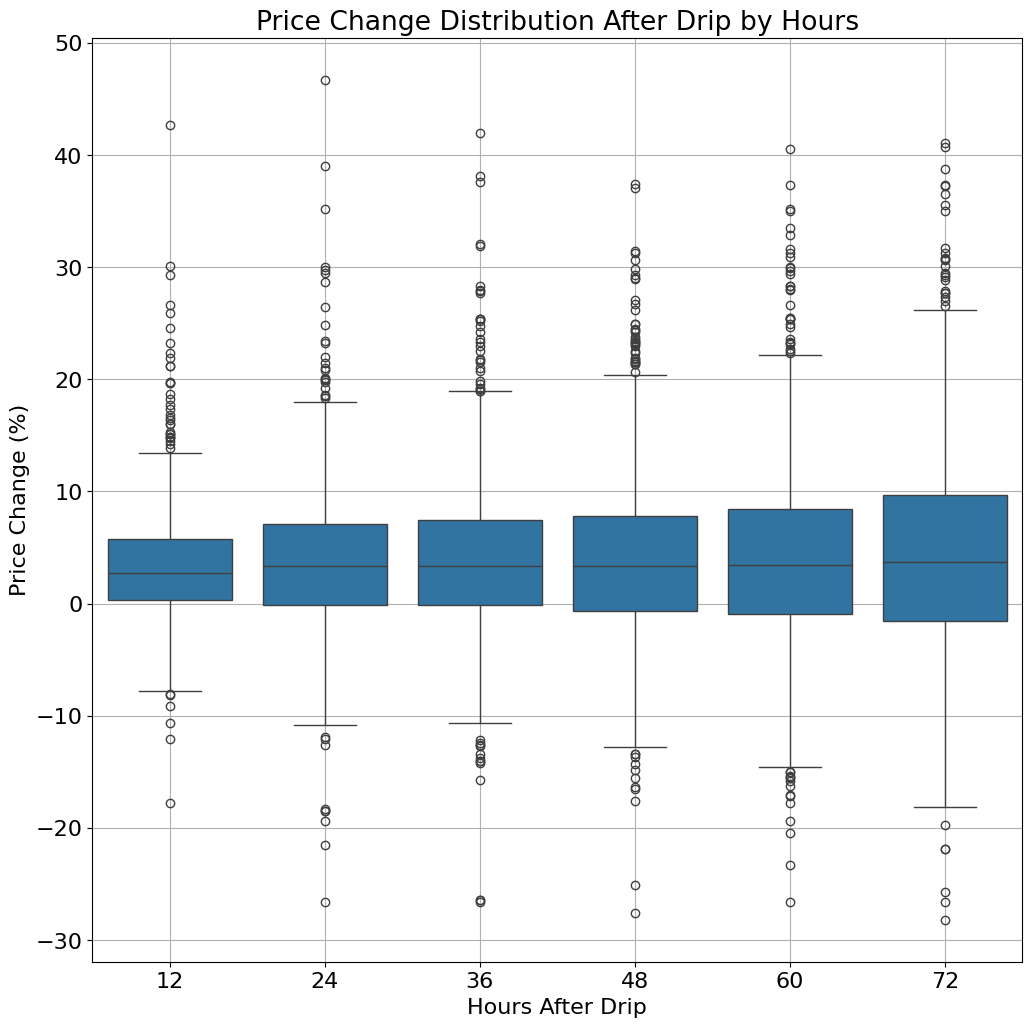

In [7]:
# สร้าง Boxplot เพื่อแสดงการกระจายของ % การเปลี่ยนแปลง
plt.figure(figsize=(12, 12))
sns.boxplot(x='hours', y='price_change', data=price_changes)
plt.title('Price Change Distribution After Drip by Hours')
plt.xlabel('Hours After Drip')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.show()

In [8]:
# 2. One-Way ANOVA Test: เปรียบเทียบค่าเฉลี่ยระหว่างกรอบเวลา
if len(price_changes['hours'].unique()) > 2:
    groups = [price_changes[price_changes['hours'] == h]['price_change'].dropna() for h in post_hours]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("There is a significant difference in mean price changes between time frames (p < 0.05)")
    else:
        print("No significant difference in mean price changes between time frames (p >= 0.05)")
else:
    print("\nANOVA Test: Not enough time frames to perform the test.")


One-Way ANOVA Test: F=1.2714, p-value=0.2732
No significant difference in mean price changes between time frames (p >= 0.05)


In [9]:
# 3. T-Test: เปรียบเทียบค่าเฉลี่ยระหว่างคู่กรอบเวลา
print("\nT-Test Results (p-values for pairwise comparisons):")
t_test_results = []
hour_pairs = list(itertools.combinations(post_hours, 2))
for h1, h2 in hour_pairs:
    group1 = price_changes[price_changes['hours'] == h1]['price_change'].dropna()
    group2 = price_changes[price_changes['hours'] == h2]['price_change'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Hour Pair': f'{h1} vs {h2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results (p-values for pairwise comparisons):
   Hour Pair  T-Statistic  P-Value
0   12 vs 24      -1.3740   0.1696
1   12 vs 36      -1.5023   0.1333
2   12 vs 48      -1.9227   0.0547
3   12 vs 60      -1.9671   0.0494
4   12 vs 72      -2.3389   0.0195
5   24 vs 36      -0.1773   0.8593
6   24 vs 48      -0.6238   0.5328
7   24 vs 60      -0.7403   0.4592
8   24 vs 72      -1.1511   0.2499
9   36 vs 48      -0.4386   0.6610
10  36 vs 60      -0.5614   0.5746
11  36 vs 72      -0.9695   0.3325
12  48 vs 60      -0.1391   0.8894
13  48 vs 72      -0.5530   0.5803
14  60 vs 72      -0.4039   0.6864


In [10]:
# 4. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ยระหว่างทุกกรอบเวลา
if len(price_changes['hours'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=price_changes['price_change'].dropna(), groups=price_changes['hours'], alpha=0.05)
    print("\nTukey’s HSD Test Results:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough time frames to perform the test.")


Tukey’s HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    12     24   0.4704 0.8869 -0.7638 1.7046  False
    12     36   0.5411  0.812 -0.6931 1.7753  False
    12     48   0.7303 0.5405 -0.5039 1.9646  False
    12     60   0.7956 0.4415 -0.4387 2.0298  False
    12     72    1.001 0.1892 -0.2332 2.2353  False
    24     36   0.0707    1.0 -1.1635  1.305  False
    24     48   0.2599  0.991 -0.9743 1.4942  False
    24     60   0.3252 0.9754 -0.9091 1.5594  False
    24     72   0.5306 0.8244 -0.7036 1.7649  False
    36     48   0.1892  0.998  -1.045 1.4235  False
    36     60   0.2544 0.9919 -0.9798 1.4887  False
    36     72   0.4599 0.8962 -0.7743 1.6942  False
    48     60   0.0652    1.0  -1.169 1.2995  False
    48     72   0.2707 0.9892 -0.9635 1.5049  False
    60     72   0.2055  0.997 -1.0288 1.4397  False
-------------------------------------

In [11]:
# 5. F-Test: เปรียบเทียบความแปรปรวนระหว่างคู่กรอบเวลา
print("\nF-Test Results (p-values for pairwise variance comparisons):")
f_test_results = []
for h1, h2 in hour_pairs:
    group1 = price_changes[price_changes['hours'] == h1]['price_change'].dropna()
    group2 = price_changes[price_changes['hours'] == h2]['price_change'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Hour Pair': f'{h1} vs {h2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results (p-values for pairwise variance comparisons):
   Hour Pair  F-Statistic  P-Value
0   12 vs 24       1.6678   0.0000
1   12 vs 36       1.9533   0.0000
2   12 vs 48       2.2842   0.0000
3   12 vs 60       2.7232   0.0000
4   12 vs 72       3.1698   0.0000
5   24 vs 36       1.1712   0.0177
6   24 vs 48       1.3696   0.0000
7   24 vs 60       1.6328   0.0000
8   24 vs 72       1.9006   0.0000
9   36 vs 48       1.1694   0.0186
10  36 vs 60       1.3941   0.0000
11  36 vs 72       1.6228   0.0000
12  48 vs 60       1.1921   0.0097
13  48 vs 72       1.3877   0.0000
14  60 vs 72       1.1640   0.0216


In [12]:
# 6. Levene’s Test: เปรียบเทียบความแปรปรวนระหว่างทุกกรอบเวลา
if len(price_changes['hours'].unique()) > 2:
    groups = [price_changes[price_changes['hours'] == h]['price_change'].dropna() for h in post_hours]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")
else:
    print("\nLevene’s Test: Not enough time frames to perform the test.")


Levene’s Test for Variance: stat=34.3142, p-value=0.0000
Variances are significantly different (p < 0.05)
